In [34]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
# matplotlib.style.use('ggplot')
plt.style.use('ggplot')

### Principal Component Analysis (PCA)
Principal component analysis is a fast and flexible unsupervised alogrithm for dimensionality reduction. We will be using PCA to extract OnlineNewsPopularity dataset. As this dataset have high dimensionality, which contains 60 columns and 39644 records. With such high number of dimension we might not be able generalize well.

We need to take note that PCA only works well with normalize dataset. The PCA calculates a new projection of your data set. And the new axis are based on the standard deviation of your variables. So a variable with a high standard deviation will have a higher weight for the calculation of axis than a variable with a low standard deviation.

We are not targeting last element, shares.<br>
Target is element 45, global_sentiment_polarity:     Text sentiment polarity

In [72]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:45] + headers[46:]
        headers = [x.strip(' ') for x in headers]
        
        temp_data = []
        temp_label = []
        
        # Target element 45 global_sentiment_polarity
        for idx, row in enumerate(reader):            
            slice_row = row[1:45] + row[46:]
            temp_data.append(slice_row)
            temp_label.append(row[45])
        
        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))                
    
        if is_normalize:
            # it is important which type of normalization method you use
            scaler = preprocessing.MinMaxScaler()
            dataset = scaler.fit_transform(dataset)
            # last item uses MinMaxScaler
            labels = np.array(labels).reshape(-1, 1)
            scaler = preprocessing.MinMaxScaler()
            labels = scaler.fit_transform(labels)
            print('Data is normalize')
        else:
            print('No normalize apply')        
            
        if is_remove_outlier:
            dataset, labels = reject_outliers(dataset, labels)    
            
        if 0 < select_top < len(dataset):            
            top_features = pca_important_features(dataset, headers, top=select_top)
            feature_keys = [f[1] for f in top_features]
            df = pd.DataFrame(dataset, columns=headers)
            top_dataset = []
            for name in feature_keys:
                top_dataset.append(df.loc[:, name])
            dataset = np.transpose(top_dataset)
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=40):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

Target is element 45, global_sentiment_polarity:     Text sentiment polarity

In [75]:
# Splitting of dataset into train and test
dataset = []
labels = []
x, y = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=-1)
print('Dataset shape: {0}, Labels: {1}'.format(x.shape, y.shape))
print()
print(headers)

Data is normalize
Outlier removed: 0
Dataset shape: (39644, 59), Labels: (39644, 1)

['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 

### Estimating number of components
A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components:<br>
<br>
Dataset have to be normalize. <br>
From the graph we can see that we need 40 components

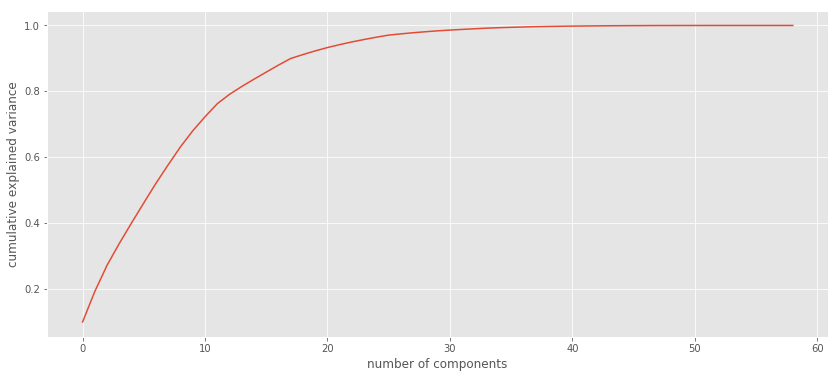

In [78]:
# Estimate number of components needed
pca = PCA().fit(x)
plt.figure(figsize=(14,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [77]:
# Splitting of dataset into train and test
# Dataset if normalize using MinMaxScaler
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=40)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

Data is normalize
Outlier removed: 0
Features by top 40 importance:
(1.0039281926912536, 'data_channel_is_world')
(0.8751808255851463, 'data_channel_is_tech')
(0.7164838485443992, 'LDA_02')
(0.7024504221910435, 'LDA_04')
(0.643485738200486, 'data_channel_is_entertainment')
(0.45655163210314703, 'LDA_03')
(0.2829290243646777, 'LDA_01')
(0.2753936992626821, 'title_subjectivity')
(0.27141665959140876, 'abs_title_subjectivity')
(0.26160822753207413, 'timedelta')
(0.24505377501984496, 'data_channel_is_bus')
(0.19651813942736646, 'kw_min_avg')
(0.19502718246107198, 'LDA_00')
(0.17612026338273556, 'min_negative_polarity')
(0.1721170943797148, 'abs_title_sentiment_polarity')
(0.16657852967652664, 'rate_positive_words')
(0.15599370115509212, 'kw_max_max')
(0.1357431818887501, 'kw_avg_max')
(0.12354845853099779, 'max_positive_polarity')
(0.11758166273091075, 'rate_negative_words')
(0.11283502834539562, 'num_keywords')
(0.1050853267850151, 'kw_min_min')
(0.09904889442894366, 'global_rate_positive